In [1]:
%cd ..
from experiment_control.srs_microscope.plot_srs import *

C:\Users\Prismo\Documents\Github\experiment_control


In [70]:
def plot_scan_data(ds, wf_cmap=cm.binary, laser_cmap=cm.Reds, srs_cmap=cm.inferno):
    """
    Plot 2x1 subplots with [0] laser spot superimposed on cropped widefield image, and [1] SRS image
    :param ds: from collect_scan()
    :return: fig with (2) subplots
    """
    laser_cmap = transparent_cmap(laser_cmap)
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Find wf image indices corresponding to scan area, add manual offset to match scan area
    i_xmax, i_xmin, i_ymax, i_ymin = wf_img_inds(ds)
    x_off = 3 *u.um
    y_off = 30 *u.um
    i_xmax += x_off.m
    i_xmin += x_off.m
    i_ymin += y_off.m
    i_ymax += y_off.m

    # [0] Laser spot + cropped widefield image
    im0 = ax[0].pcolormesh((ds["y_img"]-8*u.um)[i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
                           ds["wf_img"][i_xmax:i_xmin:-1, i_ymin:i_ymax], cmap=wf_cmap)
    im1 = ax[0].pcolormesh((ds["y_img"]-8*u.um)[i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
                           ds["laser_spot_img"][i_xmax:i_xmin:-1, i_ymin:i_ymax], cmap=laser_cmap)
    cb0 = plt.colorbar(im1, ax=ax[0])
    ax[0].set_aspect("equal")

    # [1] SRS (galvo) image
    p0 = ax[1].pcolormesh(ds["y"].m, ds["x"].m, np.flipud(np.transpose(ds["Vsrs_g"].m)), cmap=srs_cmap)
    cb1 = plt.colorbar(p0, ax=ax[1])
    ax[1].set_aspect("equal")

    plt.show()
    return fig

# Plotting scan data

loading file: GalvoScan_SiCantilevers_10uV10ms_test9_2024-04-18-18-41-24.h5
importing Dev2...
importing Vsrs_g...
importing Vx...
importing Vy...
importing laser_spot_img...
importing t...
importing wf_img...
importing x...
importing x_img...
importing y...
importing y_img...
importing attr Vx0...
volt
importing attr Vx0_units...
importing attr Vy0...
volt
importing attr Vy0_units...
importing attr dx_dVx...
micrometer / volt
importing attr dx_dVx_units...
importing attr dx_dpix...
micrometer
importing attr dx_dpix_units...
importing attr dy_dVy...
micrometer / volt
importing attr dy_dVy_units...


<ipython-input-70-f44dcc0e17e0>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[0].pcolormesh((ds["y_img"]-8*u.um)[i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
<ipython-input-70-f44dcc0e17e0>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[0].pcolormesh((ds["y_img"]-8*u.um)[i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
<ipython-input-70-f44dcc0e17e0>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as 

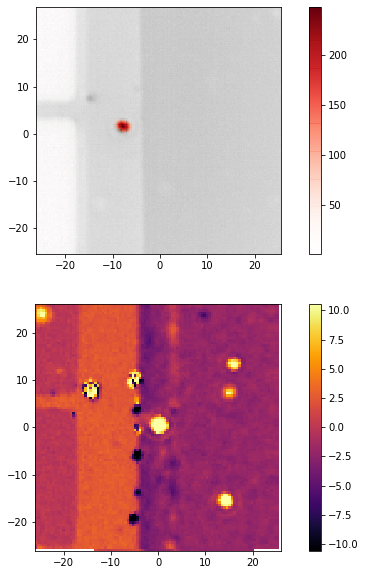

In [71]:
# Load and Plot saved dataset

sample_dir = "Sample_Solstis985.53_OEland1037.77_R_2024-04-18-16-48-57"
filename = "GalvoScan_SiCantilevers_10uV10ms_test9_2024-04-18-18-41-24.h5"
ds = load_data_from_file(sample_dir, filename)
fig = plot_scan_data(ds, wf_cmap=cm.binary, laser_cmap=cm.Reds, srs_cmap=cm.inferno)

loading file: GalvoScan_SiCantilevers_10uV30ms_test5_2024-04-17-22-38-58.h5
importing Dev2...
importing Vsrs_g...
importing Vx...
importing Vy...
importing laser_spot_img...
importing t...
importing wf_img...
importing x...
importing x_img...
importing y...
importing y_img...
importing attr Vx0...
volt
importing attr Vx0_units...
importing attr Vy0...
volt
importing attr Vy0_units...
importing attr dx_dVx...
micrometer / volt
importing attr dx_dVx_units...
importing attr dx_dpix...
micrometer
importing attr dx_dpix_units...
importing attr dy_dVy...
micrometer / volt
importing attr dy_dVy_units...


C:\Users\Prismo\AppData\Local\Temp\ipykernel_10696\3832818763.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax[0].pcolormesh(ds["y_img"][i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
C:\Users\Prismo\AppData\Local\Temp\ipykernel_10696\3832818763.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[0].pcolormesh(ds["y_img"][i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
C:\Users\Prismo\AppData\Local\Temp\ipykernel_10696\3832818763.py:28: Matpl

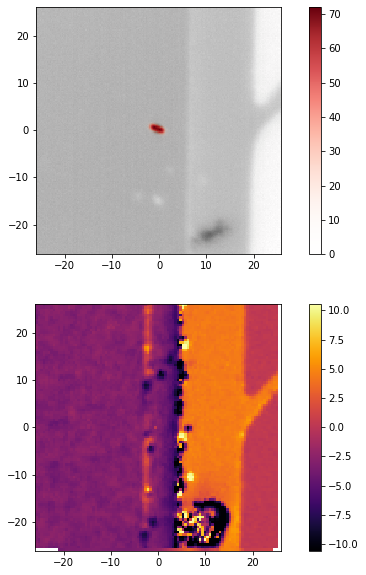

In [24]:
# Load and Plot saved dataset

sample_dir = "Sample_Solstis985.5_OEland1037.77_R_2024-04-17-13-39-23"
filename = "GalvoScan_SiCantilevers_10uV30ms_test5_2024-04-17-22-38-58.h5"
ds = load_data_from_file(sample_dir, filename)
fig = plot_scan_data(ds, wf_cmap=cm.binary, laser_cmap=cm.Reds, srs_cmap=cm.inferno)

# Laser Spot analysis

In [2]:
from cv2 import imread

C:\Users\Prismo\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)
C:\Users\Prismo\Documents\Github\experiment_control\experiment_control\srs_microscope\plot_srs.py:332: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax.pcolormesh(y_img, x_img, img[::-1, :], cmap=wf_cmap)


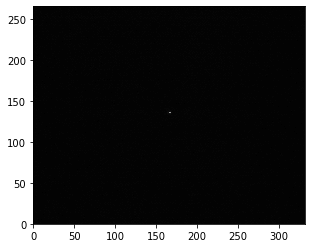

In [31]:
#Extract image array from saved .tif 

sample_dir = "Sample_Nikon20x_y_2024-04-11-17-40-38"
img_name = "knifeEdgeR_AuSi_Solstis985_pos40_25ms.tif"
img_dir = os.path.join("experiment_control",img_name)

img = imread(img_name)
img = np.sum(img, axis=-1)
fig = plot_widefield_img(img, wf_cmap='gray')

C:\Users\Prismo\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)
C:\Users\Prismo\Documents\Github\experiment_control\experiment_control\srs_microscope\plot_srs.py:165: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p0 = ax[1,0].pcolormesh(X,Y,np.fliplr(Z.T),cmap=laser_cmap)
C:\Users\Prismo\miniconda3\lib\site-packages\numpy\ma\core.py:2826: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


(<Figure size 337.5x337.5 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'FWHM: 1.52 μm'}>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='x (μm)', ylabel='y (μm)'>, <AxesSubplot:>]],
       dtype=object))

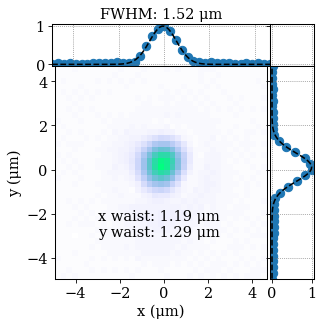

In [32]:
plot_spotzoom_wf(img)

loading file: knifeScan_Solstis985_pos10_2024-04-19-16-52-21.h5
importing pd_arr...
importing pos_arr...
importing attr axis...
importing attr num_avg...
importing attr scan_length...
micrometer
importing attr scan_length_units...
importing attr step_size...
micrometer
importing attr step_size_units...
σ = 0.69μm


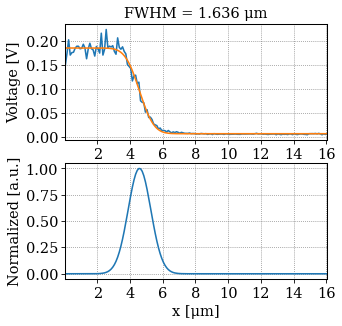

In [25]:
#Knife Edge Measurement

sample_dir = "Sample_Nikon20xR_y_SiAu_2024-04-19-13-33-19"
filename = "knifeScan_Solstis985_pos10_2024-04-19-16-52-21.h5"
ds_spot = load_data_from_file(sample_dir, filename)

fig = plot_knife_scan(ds_spot)

C:\Users\Prismo\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1333: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


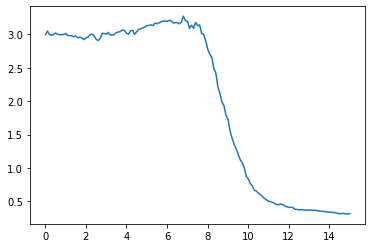

In [37]:
plt.figure()
plt.plot(ds_spot["pos_arr"],ds_spot["pd_arr"])
plt.show()

# Plot spectra

loading file: Spectra_test_2024-04-10-19-16-21.h5
importing raman_shift...
importing spec...
importing tap_power...
importing wavelengths...
importing attr fixed_wav...
nanometer
importing attr fixed_wav_units...
importing attr fsamp...
hertz
importing attr fsamp_units...
importing attr num_avg...
importing attr wav_settle_time...
second
importing attr wav_settle_time_units...
importing attr wav_start...
nanometer
importing attr wav_start_units...
importing attr wav_stop...
nanometer
importing attr wav_stop_units...
importing attr Δwav...
nanometer
importing attr Δwav_units...


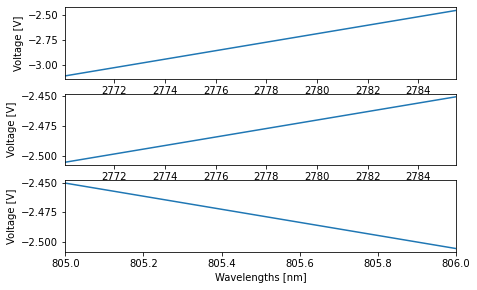

In [13]:
sample_dir = "Sample_testSpectra_Solstis940_OEland_T_2024-04-10-18-35-32"
filename = "Spectra_test_2024-04-10-19-16-21.h5"
ds_spec = load_data_from_file(sample_dir, filename)

fig=plot_spectra(ds_spec)

In [3]:
save_mat(filename, sample_dir)

loading file: Spectra_SolstisSweep_OEland_T_100ms10uV_20nm_2024-04-14-15-26-03.h5
importing raman_shift...
importing spec...
importing tap_power...
importing wavelengths...
importing attr fixed_wav...
nanometer
importing attr fixed_wav_units...
importing attr fsamp...
hertz
importing attr fsamp_units...
importing attr num_avg...
importing attr wav_settle_time...
second
importing attr wav_settle_time_units...
importing attr wav_start...
nanometer
importing attr wav_start_units...
importing attr wav_stop...
nanometer
importing attr wav_stop_units...
importing attr Δwav...
nanometer
importing attr Δwav_units...
saving data to: 
/Users/eliseuyehara/Dropbox (MIT)/POE/srs_microscope_data/srs_microscope_scans/polystyrene20um_Spectra_2024-04-14-12-58-48/Spectra_SolstisSweep_OEland_T_100ms10uV_20nm_2024-04-14-15-26-03.mat


loading file: Spectra_SolstisSweep_OEland_T_2024-04-12-16-50-46.h5
importing raman_shift...
importing spec...
importing tap_power...
importing wavelengths...
importing attr fixed_wav...
nanometer
importing attr fixed_wav_units...
importing attr fsamp...
hertz
importing attr fsamp_units...
importing attr num_avg...
importing attr wav_settle_time...
second
importing attr wav_settle_time_units...
importing attr wav_start...
nanometer
importing attr wav_start_units...
importing attr wav_stop...
nanometer
importing attr wav_stop_units...
importing attr Δwav...
nanometer
importing attr Δwav_units...


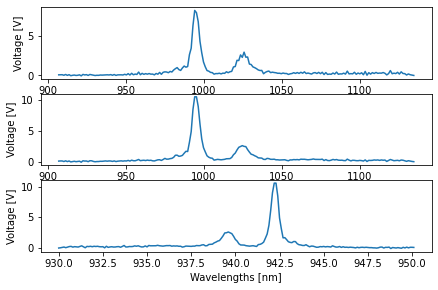

In [5]:
sample_dir = "Sample_polystyrene_bulk_2024-04-12-16-50-21"
filename = "Spectra_SolstisSweep_OEland_T_2024-04-12-16-50-46.h5"
ds_spec = load_data_from_file(sample_dir, filename)
fig = plot_spectra(ds_spec)

loading file: SpectraSweep_test_OElandSweep_T_10ms3uV_300s_2024-04-14-19-37-39.h5
importing spec...
importing wav_mon...
importing attr fixed_wav...
nanometer
importing attr fixed_wav_units...
importing attr fsamp...
hertz
importing attr fsamp_units...
importing attr t_lia...
millisecond
importing attr t_lia_units...
importing attr t_sweep...
second
importing attr t_sweep_units...
importing attr wav_start...
nanometer
importing attr wav_start_units...
importing attr wav_stop...
nanometer
importing attr wav_stop_units...


/Users/eliseuyehara/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/eliseuyehara/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


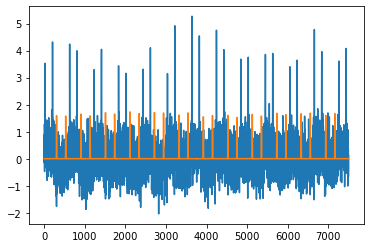

In [18]:
sample_dir = "polystyrene20um_Spectra_2024-04-14-12-58-48"
name = "SpectraSweep_test_OElandSweep_T_10ms3uV_300s_2024-04-14-19-37-39.h5"

ds_spec = load_data_from_file(sample_dir, name)

plt.figure()
plt.plot(ds_spec['spec'])
plt.plot(ds_spec['wav_mon'])

In [19]:
save_mat(name, sample_dir)

loading file: SpectraSweep_test_OElandSweep_T_10ms3uV_300s_2024-04-14-19-37-39.h5
importing spec...
importing wav_mon...
importing attr fixed_wav...
nanometer
importing attr fixed_wav_units...
importing attr fsamp...
hertz
importing attr fsamp_units...
importing attr t_lia...
millisecond
importing attr t_lia_units...
importing attr t_sweep...
second
importing attr t_sweep_units...
importing attr wav_start...
nanometer
importing attr wav_start_units...
importing attr wav_stop...
nanometer
importing attr wav_stop_units...
saving data to: 
/Users/eliseuyehara/Dropbox (MIT)/POE/srs_microscope_data/srs_microscope_scans/polystyrene20um_Spectra_2024-04-14-12-58-48/SpectraSweep_test_OElandSweep_T_10ms3uV_300s_2024-04-14-19-37-39.mat


# Old Plotting Functions

In [ ]:
# Functions for plotting data before 4/9/24

def save_scan_images(ds,fname,fpath=False,wf_cmap=cm.binary_r,laser_cmap=cm.winter,srs_cmap=cm.inferno,rc_params=srs_rc_params,format='png',**kwargs):
    """
    Save data and figs for following images:
    (1) Widefield image
    (2) Laser spot superimposed on widefield image
    (3) Widefield image zoomed 
    (4) Laser spot superimposed on cropped widefield image
    (5) SRS image
    """
    i_xmax, i_xmin, i_ymax, i_ymin = wf_img_inds(ds)
    
    x_off = 10
    y_off = 40
    i_xmax += x_off
    i_xmin += x_off
    i_ymin += y_off
    i_ymax += y_off
    
    laser_cmap = transparent_cmap(laser_cmap)
    img_data = [
#         (ds["y_img"].m, ds["x_img"].m, (np.flipud(ds["wf_img"]), ), (wf_cmap,),"wf_"+fname+"."+format),
        (ds["y_img"].m, ds["x_img"].m, (np.flipud(ds["wf_img"]), np.flipud(ds["laser_spot_img"])),(wf_cmap,laser_cmap),"wfls_"+fname+"."+format),
#         (ds["y_img"][i_ymin:i_ymax].m, ds["x_img"][i_xmin:i_xmax].m, (np.flipud(ds["wf_img"][i_xmin:i_xmax,i_ymin:i_ymax]), ), (wf_cmap,), "wfzoom_"+fname+"."+format),
        (ds["y_img"][i_ymin:i_ymax].m, ds["x_img"][i_xmin:i_xmax].m, (np.flipud(ds["wf_img"][i_xmin:i_xmax,i_ymin:i_ymax]), np.flipud(ds["laser_spot_img"][i_xmin:i_xmax,i_ymin:i_ymax])), (wf_cmap,laser_cmap), "wflszoom_"+fname+"."+format),
        (ds["y"].m, ds["x"].m, (np.flipud(np.transpose(ds["Vsig_g"].m)), ), (srs_cmap,), "srs_"+fname+"."+format),
    ]
    for X,Y,Z,cmap,fname in img_data:
         save_single_img(X,Y,Z,cmap,fname,fpath=fpath,xlabel="x (μm)",ylabel="y (μm)",cbar=False,cbar_label=None,rc_params=rc_params,format=format,**kwargs)
    return


def save_single_img(X,Y,Z,cmap,fname,fpath=False,xlabel="x (μm)",ylabel="y (μm)",cbar=False,cbar_label=None,figsize=(4,6),format='png',rc_params=srs_rc_params,**kwargs):
    """
    Given X,Y,Z arrays, plot and save figure
    """
    with mpl.rc_context(rc_params):
        fig,ax = plt.subplots(1,1) #,figsize=figsize) #**kwargs)
        ps = [ax.pcolormesh(X,Y,zz,cmap=ccmm,vmin=np.nanmin(zz),vmax=np.nanmax(zz)) for (zz,ccmm) in zip(Z,cmap) ]
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if cbar:
            cb = plt.colorbar(ps[-1],ax=ax,label=cbar_label)
        ax.set_aspect("equal")
        # fig.tight_layout()
        if fpath:
            fname=os.path.normpath(os.path.join(fpath,fname))
        plt.savefig(fname, dpi=None, facecolor=None, edgecolor=None,
            orientation='portrait', papertype=None, format=format,
            transparent=True, bbox_inches=None, pad_inches=0.5)
    return fig

def plot_scan_data(ds,wf_cmap=cm.binary,laser_cmap=cm.Reds, srs_cmap=cm.inferno):
    """
    Plot 2x1 subplots with [0] laser spot superimposed on cropped widefield image, and [1] SRS image
    :param ds: from collect_scan()
    :return: fig with (2) subplots
    """
    laser_cmap = transparent_cmap(laser_cmap)
    fig, ax = plt.subplots(2,1, figsize = (10,10))
    
    # Find wf image indices corresponding to scan area, add manual offset to match scan area
    i_xmax, i_xmin, i_ymax, i_ymin = wf_img_inds(ds)
    x_off = 10
    y_off = 40
    i_xmax += x_off
    i_xmin += x_off
    i_ymin += y_off
    i_ymax += y_off
 
    # [0] Laser spot + cropped widefield image
    im0 = ax[0].pcolormesh(ds["y_img"][i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
                              ds["wf_img"][i_xmax:i_xmin:-1, i_ymin:i_ymax], cmap=wf_cmap)
    im1 = ax[0].pcolormesh(ds["y_img"][i_ymin:i_ymax], ds["x_img"][i_xmin:i_xmax],
                              ds["laser_spot_img"][i_xmax:i_xmin:-1, i_ymin:i_ymax], cmap=laser_cmap)
    cb0 = plt.colorbar(im1, ax=ax[0])
    ax[0].set_aspect("equal")

    # [1] SRS (galvo) image
    p0 = ax[1].pcolormesh(ds["y"].m, ds["x"].m, np.flipud(np.transpose(ds["Vsig_g"].m)), cmap=srs_cmap)
    cb1 = plt.colorbar(p0, ax=ax[1])
    ax[1].set_aspect("equal")

    plt.show()
    return fig